In [1]:
# This is Multi-Class SVM for comparison

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.svm import SVC


In [17]:
from BCI2kReader import BCI2kReader as b2k

with b2k.BCI2kReader('/Users/robinsierratuscher/Desktop/PF32_2016_08_12_train32FFS001R02.dat') as test: #opens a stream to the dat file
    test.samplingrate # sampling rate

In [18]:
my_signals=test.signals #reads the whole file and stores it in a numpy matrix channels(channels,datapoints) 
#my_states=test.states #reads all states as a dictionary .. 
#my_signals, my_states=test.readall() # my_signals, my_states=test.read(-1) # reads from current position until end
#my_states[‘Running’] # access to the Running state

In [19]:
my_states = test.states

In [20]:
X = np.transpose(my_signals)
#scale X here?

In [21]:
y = np.transpose(my_states['StimulusType'])
y = y[:,0]
y_multiclass = np.zeros(51712)
for i in range(0,51712):
    if ((y[i] == 1) and (i >= 0) and (i <= 7889)):
        y_multiclass[i] = 1 # T
    elif ((y[i] == 1) and (i >= 8030) and (i <= 12784)):
        y_multiclass[i] = 2 # H
    elif ((y[i] == 1) and (i >= 14010) and (i <= 17552)):
        y_multiclass[i] = 3 # E
    elif ((y[i] == 1) and ((i >= 18654) and (i <= 22193)) or ((i >= 47040) and (i <= 50767)) ):
        y_multiclass[i] = 4 # ->
    elif ((y[i] == 1) and (i >= 23355) and (i <= 27090)):
        y_multiclass[i] = 5 # Q
    elif ((y[i] == 1) and (i >= 28120) and (i <= 31699)):
        y_multiclass[i] = 6 # U
    elif ((y[i] == 1) and (i >= 32990) and (i <= 36478)):
        y_multiclass[i] = 7 # I
    elif ((y[i] == 1) and (i >= 36480) and (i <= 41103)):
        y_multiclass[i] = 8 # C
    elif ((y[i] == 1) and (i >= 42432) and (i <= 45871)):
        y_multiclass[i] = 9 # K


Text(0, 0.5, 'Channels')

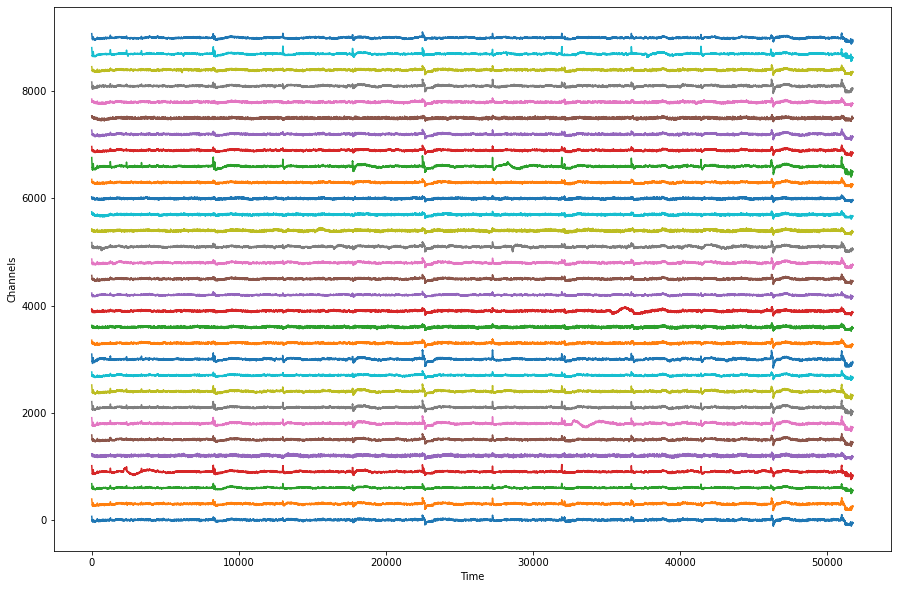

In [22]:
plt.figure(figsize = (15,10))
for y in range(0,31):
    plt.plot((300*y)+X[:,y])
plt.xlabel('Time')
plt.ylabel('Channels')

In [8]:
label_m = np.empty(51712, dtype = str)
label_m[0] = ' '
label_m[10] = 'T'
label_m[10000] = 'H'
label_m[15000] = 'E'
label_m[20000] = '->'
label_m[25000] = 'Q'
label_m[30000] = 'U'
label_m[35000] = 'I'
label_m[40000] = 'C'
label_m[45000] = 'K'

Text(0, 0.5, 'Letter Causing P300')

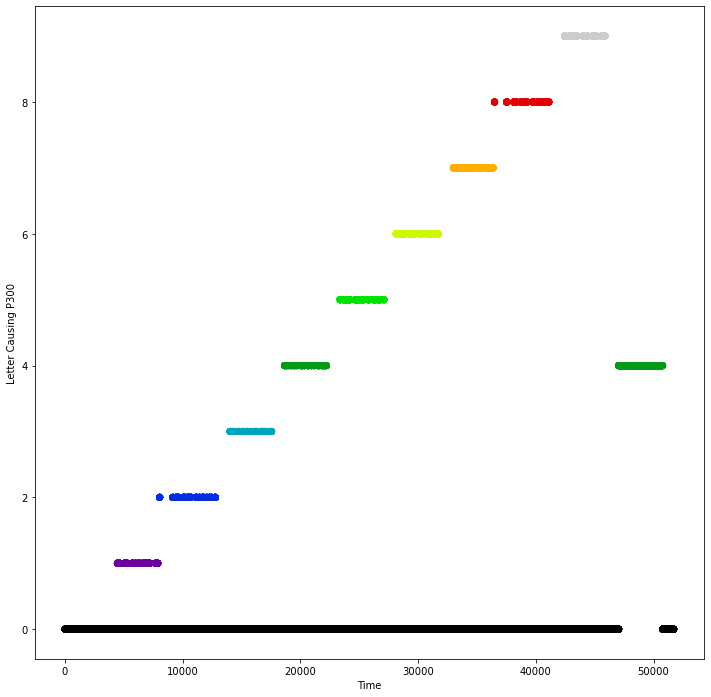

In [9]:
plt.figure(figsize = (12,12))
t = np.linspace(0,51713, 51712)
plt.scatter(t,y_multiclass, c = y_multiclass, cmap = "nipy_spectral")
#plt.scatter(t[(0,10,10000,15000,20000,30000,35000,40000,45000),],y_multiclass[(0,10,10000,15000,20000,30000,35000,40000,45000),], c = y_multiclass[(0,10,10000,15000,20000,30000,35000,40000,45000),], label = label_m[(0,10,10000,15000,20000,30000,35000,40000,45000),], cmap = "nipy_spectral")

plt.xlabel('Time')
plt.ylabel('Letter Causing P300')


Text(0, 0.5, 'PC2')

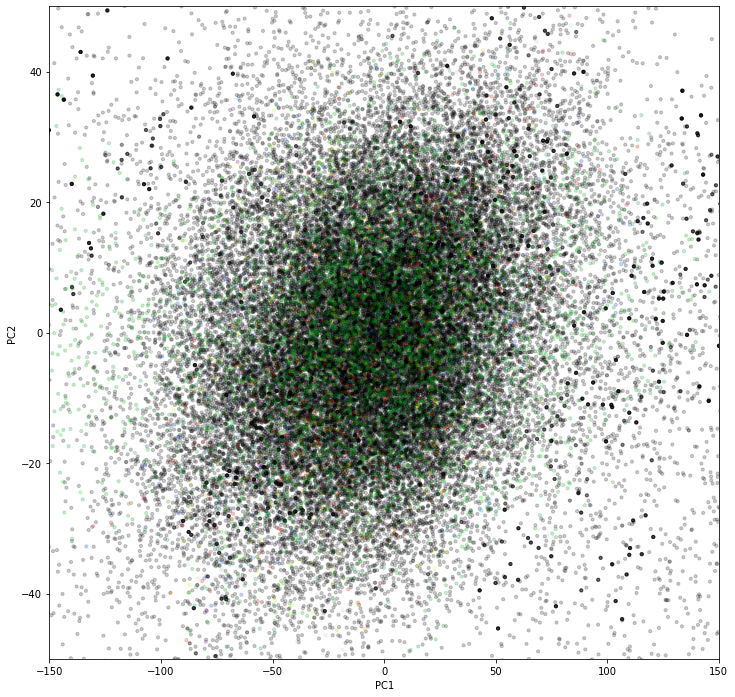

In [10]:
# PCA plot for multi class using same coloring as prior graph
pca = PCA(n_components=2)
X_s = pca.fit_transform(X)

plt.figure(figsize = (12,12))
plt.scatter(X_s[:, 0], X_s[:, 1], c=y_multiclass, cmap = "nipy_spectral", s=10, alpha = 0.2)
plt.xlim(-150,150)
plt.ylim(-50,50)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [11]:
#CV of PCA and multiclass SVM modeling together, one-vs-rest which performs better

kf = KFold(n_splits=5, shuffle=True)
X = scale(X)
j = 0
pred_scores = np.ones(5)
for train_index, test_index in kf.split(X):
    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X[train_index])
    model = SVC(kernel='rbf', C = .1, gamma = .1)
    model.fit(X_r, y_multiclass[train_index])
    pred_scores[j] = model.score(pca.transform(X[test_index]), y_multiclass[test_index])
    j = j+1
print(np.mean(pred_scores))

/Users/robinsierratuscher/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/robinsierratuscher/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


0.872756832821423


In [12]:
#adapted from dr. meyer's code, used to plot decision boundaries

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P0 = model.decision_function(xy)[:,0].reshape(X.shape)
    P1 = model.decision_function(xy)[:,1].reshape(X.shape)
    P2 = model.decision_function(xy)[:,2].reshape(X.shape)
    P3 = model.decision_function(xy)[:,3].reshape(X.shape)
    P4 = model.decision_function(xy)[:,4].reshape(X.shape)
    P5 = model.decision_function(xy)[:,5].reshape(X.shape)
    P6 = model.decision_function(xy)[:,6].reshape(X.shape)
    P7 = model.decision_function(xy)[:,7].reshape(X.shape)
    P8 = model.decision_function(xy)[:,8].reshape(X.shape)
    P9 = model.decision_function(xy)[:,9].reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P0, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P1, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P2, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P3, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P4, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P5, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P6, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P7, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.contour(X, Y, P8, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])  
    ax.contour(X, Y, P9, colors='r',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<ipython-input-12-06c755321694>:27: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P0, colors='r',
<ipython-input-12-06c755321694>:33: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P2, colors='r',
<ipython-input-12-06c755321694>:36: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P3, colors='r',
<ipython-input-12-06c755321694>:39: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P4, colors='r',
<ipython-input-12-06c755321694>:42: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P5, colors='r',
<ipython-input-12-06c755321694>:45: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P6, colors='r',
<ipython-input-12-06c755321694>:51: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, P8, colors='r',
<ipython-input-12-06c755321694>:54: UserWarning:

0.8722153465346535


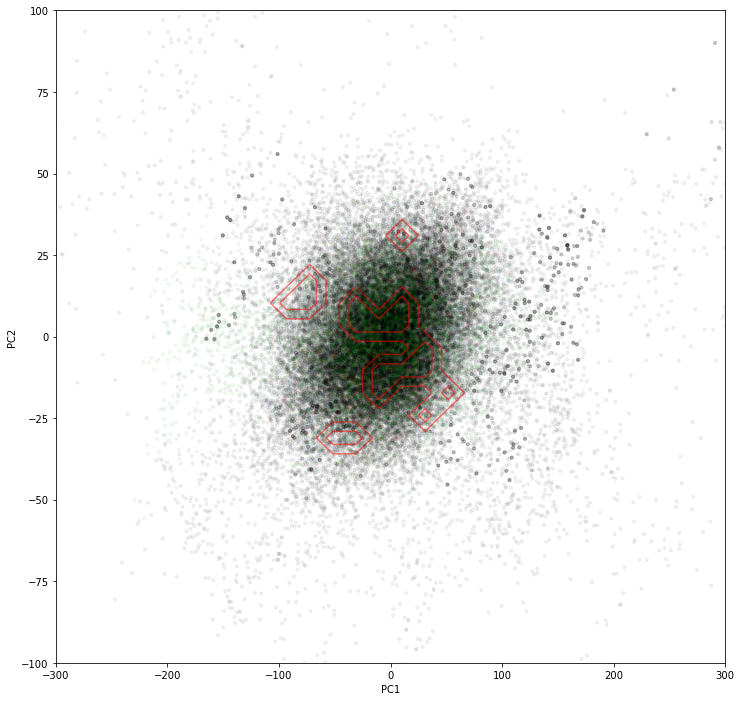

In [13]:
#the actual model, SVM multiclass to find fit score and to plot

model = SVC(kernel='rbf', C = .1, gamma = .1)
model.fit(X_s, y_multiclass)

plt.figure(figsize = (12,12))
plt.scatter(X_s[:, 0], X_s[:, 1], c=y_multiclass, cmap = "nipy_spectral", s=10, alpha = 0.05)
plt.xlim(-300,300)
plt.ylim(-100,100)
plt.xlabel('PC1')
plt.ylabel('PC2')
plot_svc_decision_function(model);

print(model.score(X_s,y_multiclass))

In [14]:
#CV of PCA and multiclass SVM modeling together, one-vs-one

kf = KFold(n_splits=5, shuffle=True)
X = scale(X)
j = 0
pred_scores = np.ones(5)
for train_index, test_index in kf.split(X):
    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X[train_index])
    model = SVC(kernel='rbf', C = .1, gamma = .1, decision_function_shape='ovo')
    model.fit(X_r, y_multiclass[train_index])
    pred_scores[j] = model.score(pca.transform(X[test_index]), y_multiclass[test_index])
    j = j+1
print(np.mean(pred_scores))

0.8726989141897243
